<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Deep-Deterministic-Policy-Gradients-(DDPG)" data-toc-modified-id="Deep-Deterministic-Policy-Gradients-(DDPG)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Deep Deterministic Policy Gradients (DDPG)</a></span><ul class="toc-item"><li><span><a href="#Import-the-Necessary-Packages" data-toc-modified-id="Import-the-Necessary-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import the Necessary Packages</a></span></li><li><span><a href="#Instantiate-the-Environment-and-Agent" data-toc-modified-id="Instantiate-the-Environment-and-Agent-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Instantiate the Environment and Agent</a></span><ul class="toc-item"><li><span><a href="#Examine-the-state-and-action-spaces" data-toc-modified-id="Examine-the-state-and-action-spaces-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Examine the state and action spaces</a></span></li></ul></li><li><span><a href="#Train-the-Agent-with-DDPG" data-toc-modified-id="Train-the-Agent-with-DDPG-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train the Agent with DDPG</a></span><ul class="toc-item"><li><span><a href="#4.-Watch-the-Smart-Agent!" data-toc-modified-id="4.-Watch-the-Smart-Agent!-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>4. Watch the Smart Agent!</a></span></li></ul></li></ul></li></ul></div>

# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with OpenAI Gym's BipedalWalker-v2 environment.

## Import the Necessary Packages

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import importlib

import ddpg_agent
import prioritized_ddpg_agent

importlib.reload(prioritized_ddpg_agent)

<module 'prioritized_ddpg_agent' from 'C:\\Users\\thoma\\Documents\\GitHub\\deep-reinforcement-learning\\p2_continuous-control\\prioritized_ddpg_agent.py'>

## Instantiate the Environment and Agent

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

UnityTimeOutException: The Unity environment took too long to respond. Make sure that :
	 The environment does not need user interaction to launch
	 The Academy and the External Brain(s) are attached to objects in the Scene
	 The environment and the Python interface have compatible versions.

Creating functions for common environment processes

In [ ]:
def environment_step(env, action, brain_name):
    env_info = env.step(action)[brain_name]
    next_states = env_info.vector_observations   # get the next state
    rewards = env_info.rewards                   # get the reward
    dones = env_info.local_done 
    
    return next_states, rewards, dones, None

def environment_reset(env, brain_name, train_mode=True):
    env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
    
    return env_info

### Examine the state and action spaces

In [ ]:
# reset the environment
env_info = environment_reset(env, brain_name)

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

## Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [ ]:
import prioritized_ddpg_agent
importlib.reload(prioritized_ddpg_agent)

agent = prioritized_ddpg_agent.PrioritizedAgent(state_size=33, action_size=4, random_seed=42)
#agent = ddpg_agent.Agent(state_size=33, action_size=4, random_seed=42)
agent.act(states, add_noise=False)

In [ ]:
import time

In [9]:
# DDPG function

def ddpg(n_episodes=3000, max_t=1000, solved_score=30.0, consec_episodes=100, print_every=1, train_mode=True,
         actor_path='actor_ckpt.pth', critic_path='critic_ckpt.pth'):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min avg score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor network weights
        critic_path (str)     : directory to store critic network weights

    """
    
    best_score = -np.inf
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards
                        
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        scores_window.append(scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  \tMov. Avg: {:.1f}'.format(\
                  i_episode, round(duration), moving_avgs[-1]))
        
        if train_mode and mean_scores[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
                  
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode-consec_episodes, moving_avgs[-1], consec_episodes))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_path)
                torch.save(agent.critic_local.state_dict(), critic_path)  
            break
            
    return mean_scores, moving_avgs

In [10]:
scores, avgs = ddpg()

Episode 1 (69 sec)  -- 	Min: 0.8	Max: 0.8	Mean: 0.8	Mov. Avg: 0.8
Episode 2 (85 sec)  -- 	Min: 0.2	Max: 0.2	Mean: 0.2	Mov. Avg: 0.5
Episode 3 (78 sec)  -- 	Min: 0.5	Max: 0.5	Mean: 0.5	Mov. Avg: 0.5
Episode 4 (91 sec)  -- 	Min: 0.3	Max: 0.3	Mean: 0.3	Mov. Avg: 0.4
Episode 5 (78 sec)  -- 	Min: 0.3	Max: 0.3	Mean: 0.3	Mov. Avg: 0.4
Episode 6 (78 sec)  -- 	Min: 0.0	Max: 0.0	Mean: 0.0	Mov. Avg: 0.3
Episode 7 (78 sec)  -- 	Min: 1.8	Max: 1.8	Mean: 1.8	Mov. Avg: 0.6
Episode 8 (77 sec)  -- 	Min: 0.0	Max: 0.0	Mean: 0.0	Mov. Avg: 0.5
Episode 9 (81 sec)  -- 	Min: 0.0	Max: 0.0	Mean: 0.0	Mov. Avg: 0.4
Episode 10 (104 sec)  -- 	Min: 0.1	Max: 0.1	Mean: 0.1	Mov. Avg: 0.4
Episode 11 (95 sec)  -- 	Min: 0.8	Max: 0.8	Mean: 0.8	Mov. Avg: 0.4
Episode 12 (101 sec)  -- 	Min: 0.4	Max: 0.4	Mean: 0.4	Mov. Avg: 0.4
Episode 13 (113 sec)  -- 	Min: 0.4	Max: 0.4	Mean: 0.4	Mov. Avg: 0.4
Episode 14 (121 sec)  -- 	Min: 0.7	Max: 0.7	Mean: 0.7	Mov. Avg: 0.4
Episode 15 (103 sec)  -- 	Min: 0.0	Max: 0.0	Mean: 0.0	Mov. Avg: 0.4

Episode 122 (105 sec)  -- 	Min: 17.0	Max: 17.0	Mean: 17.0	Mov. Avg: 4.6
Episode 123 (118 sec)  -- 	Min: 4.6	Max: 4.6	Mean: 4.6	Mov. Avg: 4.6
Episode 124 (147 sec)  -- 	Min: 6.1	Max: 6.1	Mean: 6.1	Mov. Avg: 4.7
Episode 125 (149 sec)  -- 	Min: 10.1	Max: 10.1	Mean: 10.1	Mov. Avg: 4.8
Episode 126 (125 sec)  -- 	Min: 8.1	Max: 8.1	Mean: 8.1	Mov. Avg: 4.8
Episode 127 (135 sec)  -- 	Min: 9.0	Max: 9.0	Mean: 9.0	Mov. Avg: 4.9
Episode 128 (130 sec)  -- 	Min: 7.6	Max: 7.6	Mean: 7.6	Mov. Avg: 5.0
Episode 129 (117 sec)  -- 	Min: 10.3	Max: 10.3	Mean: 10.3	Mov. Avg: 5.1
Episode 130 (123 sec)  -- 	Min: 6.7	Max: 6.7	Mean: 6.7	Mov. Avg: 5.1
Episode 131 (114 sec)  -- 	Min: 5.9	Max: 5.9	Mean: 5.9	Mov. Avg: 5.1
Episode 132 (126 sec)  -- 	Min: 8.5	Max: 8.5	Mean: 8.5	Mov. Avg: 5.2
Episode 133 (135 sec)  -- 	Min: 11.0	Max: 11.0	Mean: 11.0	Mov. Avg: 5.3
Episode 134 (134 sec)  -- 	Min: 6.8	Max: 6.8	Mean: 6.8	Mov. Avg: 5.3
Episode 135 (117 sec)  -- 	Min: 4.9	Max: 4.9	Mean: 4.9	Mov. Avg: 5.3
Episode 136 (111 sec) 

Episode 238 (114 sec)  -- 	Min: 14.9	Max: 14.9	Mean: 14.9	Mov. Avg: 11.7
Episode 239 (120 sec)  -- 	Min: 12.8	Max: 12.8	Mean: 12.8	Mov. Avg: 11.8
Episode 240 (114 sec)  -- 	Min: 14.6	Max: 14.6	Mean: 14.6	Mov. Avg: 11.8
Episode 241 (115 sec)  -- 	Min: 10.8	Max: 10.8	Mean: 10.8	Mov. Avg: 11.8
Episode 242 (114 sec)  -- 	Min: 11.1	Max: 11.1	Mean: 11.1	Mov. Avg: 11.8
Episode 243 (114 sec)  -- 	Min: 14.6	Max: 14.6	Mean: 14.6	Mov. Avg: 11.8
Episode 244 (114 sec)  -- 	Min: 13.3	Max: 13.3	Mean: 13.3	Mov. Avg: 11.9
Episode 245 (118 sec)  -- 	Min: 11.2	Max: 11.2	Mean: 11.2	Mov. Avg: 12.0
Episode 246 (125 sec)  -- 	Min: 11.2	Max: 11.2	Mean: 11.2	Mov. Avg: 12.0
Episode 247 (133 sec)  -- 	Min: 11.5	Max: 11.5	Mean: 11.5	Mov. Avg: 12.0
Episode 248 (124 sec)  -- 	Min: 12.2	Max: 12.2	Mean: 12.2	Mov. Avg: 12.1
Episode 249 (125 sec)  -- 	Min: 13.2	Max: 13.2	Mean: 13.2	Mov. Avg: 12.1
Episode 250 (129 sec)  -- 	Min: 26.0	Max: 26.0	Mean: 26.0	Mov. Avg: 12.2
Episode 251 (125 sec)  -- 	Min: 12.6	Max: 12.6	Mean

Episode 351 (193 sec)  -- 	Min: 17.6	Max: 17.6	Mean: 17.6	Mov. Avg: 17.9
Episode 352 (196 sec)  -- 	Min: 12.6	Max: 12.6	Mean: 12.6	Mov. Avg: 17.9
Episode 353 (206 sec)  -- 	Min: 23.0	Max: 23.0	Mean: 23.0	Mov. Avg: 18.0
Episode 354 (199 sec)  -- 	Min: 13.0	Max: 13.0	Mean: 13.0	Mov. Avg: 18.0
Episode 355 (196 sec)  -- 	Min: 10.2	Max: 10.2	Mean: 10.2	Mov. Avg: 17.9
Episode 356 (195 sec)  -- 	Min: 19.9	Max: 19.9	Mean: 19.9	Mov. Avg: 18.0
Episode 357 (197 sec)  -- 	Min: 21.0	Max: 21.0	Mean: 21.0	Mov. Avg: 18.1
Episode 358 (208 sec)  -- 	Min: 20.9	Max: 20.9	Mean: 20.9	Mov. Avg: 18.2
Episode 359 (197 sec)  -- 	Min: 15.5	Max: 15.5	Mean: 15.5	Mov. Avg: 18.1
Episode 360 (196 sec)  -- 	Min: 25.6	Max: 25.6	Mean: 25.6	Mov. Avg: 18.2
Episode 361 (198 sec)  -- 	Min: 30.6	Max: 30.6	Mean: 30.6	Mov. Avg: 18.3
Episode 362 (208 sec)  -- 	Min: 28.8	Max: 28.8	Mean: 28.8	Mov. Avg: 18.5
Episode 363 (203 sec)  -- 	Min: 17.6	Max: 17.6	Mean: 17.6	Mov. Avg: 18.5
Episode 364 (200 sec)  -- 	Min: 26.5	Max: 26.5	Mean

Episode 464 (194 sec)  -- 	Min: 19.1	Max: 19.1	Mean: 19.1	Mov. Avg: 25.9
Episode 465 (195 sec)  -- 	Min: 29.0	Max: 29.0	Mean: 29.0	Mov. Avg: 25.8
Episode 466 (198 sec)  -- 	Min: 33.7	Max: 33.7	Mean: 33.7	Mov. Avg: 26.0
Episode 467 (201 sec)  -- 	Min: 26.2	Max: 26.2	Mean: 26.2	Mov. Avg: 25.9
Episode 468 (188 sec)  -- 	Min: 32.3	Max: 32.3	Mean: 32.3	Mov. Avg: 26.1
Episode 469 (193 sec)  -- 	Min: 29.8	Max: 29.8	Mean: 29.8	Mov. Avg: 26.2
Episode 470 (193 sec)  -- 	Min: 32.1	Max: 32.1	Mean: 32.1	Mov. Avg: 26.2
Episode 471 (203 sec)  -- 	Min: 38.8	Max: 38.8	Mean: 38.8	Mov. Avg: 26.4
Episode 472 (194 sec)  -- 	Min: 37.2	Max: 37.2	Mean: 37.2	Mov. Avg: 26.6
Episode 473 (195 sec)  -- 	Min: 32.1	Max: 32.1	Mean: 32.1	Mov. Avg: 26.6
Episode 474 (194 sec)  -- 	Min: 35.3	Max: 35.3	Mean: 35.3	Mov. Avg: 26.8
Episode 475 (200 sec)  -- 	Min: 27.7	Max: 27.7	Mean: 27.7	Mov. Avg: 26.9
Episode 476 (205 sec)  -- 	Min: 34.2	Max: 34.2	Mean: 34.2	Mov. Avg: 26.9
Episode 477 (199 sec)  -- 	Min: 35.9	Max: 35.9	Mean

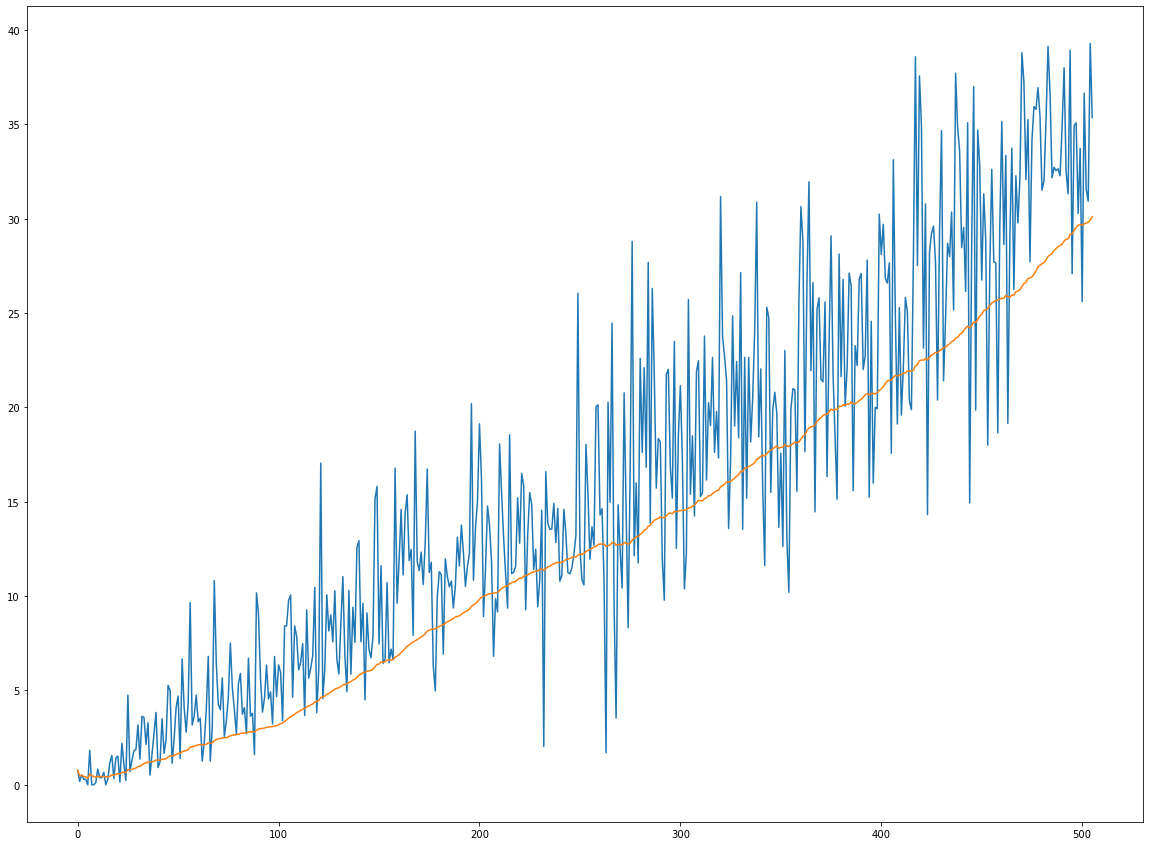

In [11]:
plt.figure(figsize=(20,15))
plt.plot(scores)
plt.plot(avgs)

### 4. Watch the Smart Agent!

In the next code cell, I load the trained weights from file to watch a smart agent!

In [ ]:
torch.save(agent.actor_local.state_dict(), "actor_weights_prioritised_replay_buffer.pth")
torch.save(agent.critic_local.state_dict(), "critic_weights_prioritised_replay_buffer.pth")  

In [ ]:
agent.actor_local.load_state_dict(torch.load('actor_weights_prioritised_replay_buffer.pth'))
agent.critic_local.load_state_dict(torch.load('critic_weights_prioritised_replay_buffer.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset environment
states = env_info.vector_observations                   # get current state for each agent    
agent.reset()   
while True:
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]            # send actions to environment
    next_states = env_info.vector_observations          # get next state
    rewards = env_info.rewards                          # get reward
    dones = env_info.local_done                         # see if episode has finished
    states = next_states
    if np.any(dones):
        break
        


In [18]:
env.close()